# CSHS Analysis
- Load Data
- Identify main ROI
- Reconstruct Datacube
- Identify particles
- Remove background signal
- Basic plot

## Imports

In [81]:
# Basic imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Useful for handling files
from os import walk
import pandas as pd
import scipy.io
import h5py
import natsort

# Used for specific CS functionality
from scipy.linalg import hadamard
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# Configure plotting - change inline to qt for windowed plots
%config Completer.use_jedi = False
%matplotlib inline

## Main functions

In [182]:
def plot_roi(datacube,i=0,j=0,box_width=10,axs=None,return_roi=False,plot=True,axis_off = True,ylim=False,n_bands=63):
    """
    Given a datacube object, plots a specified region of the datacube with its spectrum
    
    i = column index
    j = row index
    """
    i = i-int(box_width/2)
    j = j-int(box_width/2)
    
    # Get average spectrum at roi
    roi = datacube[j:j+box_width,i:i+box_width,:]
    avg = np.mean(roi,axis=0)
    avg = np.mean(avg,axis=0)
        
    if plot == True:
        if axs == None:
            fig,axs = plt.subplots(ncols=2,figsize=(8,4))

        # Plot intensity image
        axs[0].imshow(np.mean(datacube,axis=2),cmap='gray')
        # Plot ROI marker
        axs[0].plot([i,i,i+box_width,i+box_width,i],[j,j+box_width,j+box_width,j,j],'r-',markersize=15,markeredgewidth=2,alpha=.8)
        
        axs[0].set_title('Region of interest: (%i, %i) %ix%i' % (i,j,box_width,box_width))
        if axis_off == True:
            axs[0].axis('off')

        

        axs[1].plot(np.arange(1,n_bands+1),avg)
        axs[1].set_xlabel('Band number')
        axs[1].set_ylabel('Intensity')
        if type(ylim)!=type(False):
            axs[1].set_ylim(ylim)

        plt.tight_layout()
    
    if return_roi == True:
        return avg

def load_imstack(fpaths,roi=[0,100,0,100],n_bands=63, inverse=False):
    """ Given a list of filepaths, returns (imx,imy,n_bands) shape array """
    if inverse == False:
        meas = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        for i,f in enumerate(fpaths):
            # load image
            im = np.array(Image.open(f).convert('L'))
            # crop image
            im = im[roi[0]:roi[1],roi[2]:roi[3]]
            # add to stack
            meas[:,:,i] = im

        return meas
    
    if inverse == True:
        meas = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        inv = np.zeros((roi[1]-roi[0],roi[3]-roi[2],n_bands))
        for i,f in enumerate(fpaths):
            # load image
            im = np.array(Image.open(f).convert('L'))
            # crop image
            im = im[roi[0]:roi[1],roi[2]:roi[3]]
            # add to stack
            if i%2 == 0:
                meas[:,:,int(i/2)] = im
            if i%2 == 1:
                inv[:,:,int(i/2-.5)] = im
                
        return meas, inv

def reconstruct_normal(meas,bgs_avg, roi=[0,100,0,100], n_bands = 63):
    """ Given a set of Hadamard multiplexed measurements (imx,imy,n_bands) 
    in the correct order, returns a hyperspectral datacube """
    # flatten images in the image stacks
    meas_flat = np.reshape(meas,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))
    bgs_avg_flat = np.reshape(bgs_avg,(np.shape(meas)[0]*np.shape(meas)[1],1))
    
    # subtract background
    meas_norm_flat = meas_flat - bgs_avg_flat
    
    # load hadamard matrix
    # remove first row and also negative values
    sensing_mat = hadamard(n_bands+1)[1:,1:]
    sensing_mat = sensing_mat * (sensing_mat > 0)
    
    # reconstruct datacube: recon = H^-1 * meas
    cube_flat = (np.matmul(np.linalg.inv(sensing_mat),meas_norm_flat.T)).T
    
    # reshape
    cube = cube_flat.reshape((roi[1]-roi[0],roi[3]-roi[2],n_bands))
    
    return cube

def reconstruct_inverse(meas,inv,n_bands,roi):
    """ Given a set of Hadamard multiplexed measurements (imx,imy,n_bands) 
    in the correct order, as well as the inverse measurements and an ROI, returns a hyperspectral datacube """
    # flatten images in the image stacks
    meas_flat = np.reshape(meas,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))
    inv_flat = np.reshape(inv,(np.shape(meas)[0]*np.shape(meas)[1],np.shape(meas)[2]))

    # subtract background
    meas_norm_flat = (meas_flat - inv_flat)

    # shift negative values
    #meas_norm_flat = meas_norm_flat+abs(np.min(meas_norm_flat))

    # load hadamard matrix
    # remove first row and also negative values
    sensing_mat = hadamard(n_bands+1)[1:,1:]
    sensing_mat = sensing_mat * (sensing_mat > 0)

    # reconstruct datacube: recon = H^-1 * meas
    cube_flat = (np.matmul(np.linalg.inv(sensing_mat),meas_norm_flat.T)).T

    # reshape
    cube = cube_flat.reshape((roi[1]-roi[0],roi[3]-roi[2],n_bands))
    
    return cube

def get_fpaths_in_folder(folder):
    """ Folder should be ~ r'C:\path\\' 
    returns fpaths in alphabetical order """
    _, _, filenames = next(walk(folder))

    fpaths = []
    for f in filenames:
        fpaths.append(folder+f)
    
    return fpaths

def get_wavelengths(nbands=63, fpath=r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_extracted_23-04-28.npy'):
    yminmax = np.load(fpath)
    wavelengths = np.linspace(yminmax[1],yminmax[0],num=nbands)
    return wavelengths

## Get filepaths to Data

In [49]:
# Specify folder with images 
folder = r'C:\Users\er407\Desktop\DMD demo\Example Data - AuNPs_250ms_inv\\'

# Get filepaths for all images in that folder
all_fpaths = get_fpaths_in_folder(folder)

## Choose region of interest

Text(0.5, 1.0, 'Cropped ROI')

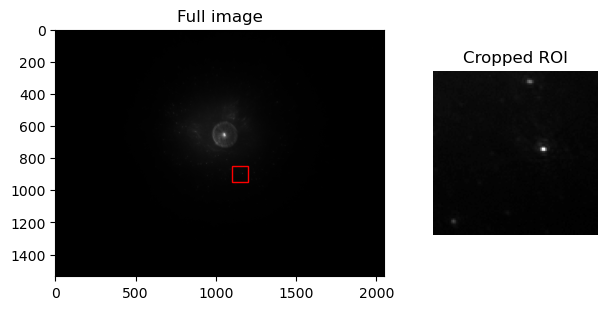

In [108]:
# Load a single image
f=all_fpaths[30]
im = np.array(Image.open(f).convert('L'))

# Determine an ROI to avoid loading the full dataset
    # Top, bottom, left, right
roi = [850,950,1100,1200]
imc = im[roi[0]:roi[1],roi[2]:roi[3]]

# Plotting
fig,axs = plt.subplots(ncols=2,figsize=(7,7),width_ratios=[2,1])
    # Full plot
axs[0].imshow(im,cmap='gray')
    # Create a Rectangle patch
b,l,w,h = roi[2],roi[0],roi[3]-roi[2],roi[1]-roi[0]
rect = patches.Rectangle((b, l), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
axs[0].add_patch(rect)
    # Add cropped image
axs[1].imshow(imc,cmap='gray')
    # Configure
axs[1].axis('off')
axs[0].set_title('Full image')
axs[1].set_title('Cropped ROI')

## Load and reconstruct datacube

In [109]:
# Load all images with that specific ROI
meas,inv = load_imstack(all_fpaths,roi=roi,inverse=True)

In [110]:
# Perform data reconstruction
cube = reconstruct_inverse(meas,inv,63,roi)

## Extract particle and background spectra

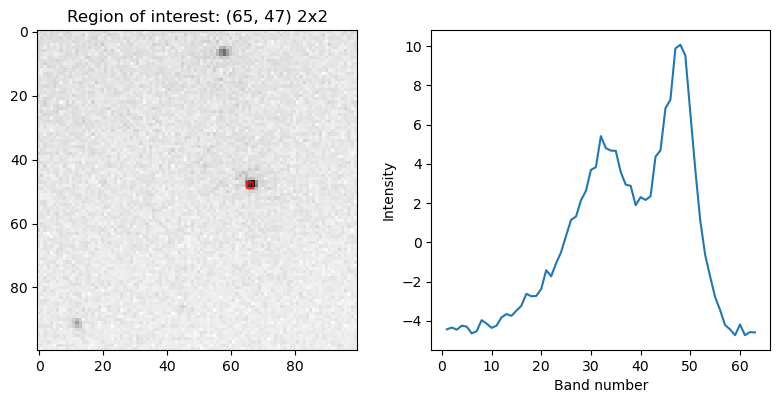

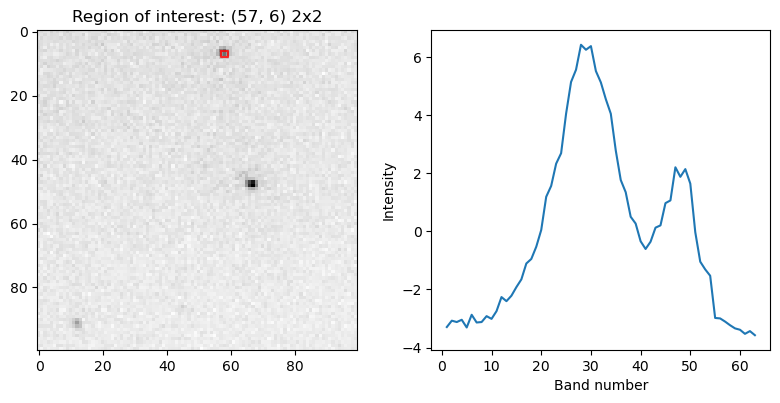

In [180]:
# Extract spectra from particles
spectrum1 = plot_roi(cube,i=66,j=48,box_width=2,axis_off=False,return_roi=True)
spectrum2 = plot_roi(cube,i=58,j=7,box_width=2,axis_off=False,return_roi=True)

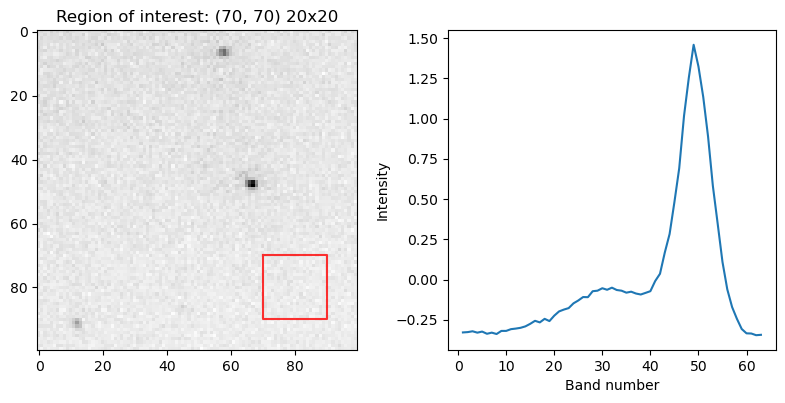

In [169]:
# Extract background spectrum
lamp = plot_roi(cube,i=80,j=80,box_width=20,axis_off=False,return_roi=True)
lmax = np.max(lamp)

## Load wavelengths

In [183]:
# Extract wavelengths
wavelengths = get_wavelengths(nbands=63, fpath=r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_extracted_23-04-28.npy')
wavelengths

array([654.91065289, 651.5479503 , 648.18524771, 644.82254511,
       641.45984252, 638.09713993, 634.73443734, 631.37173474,
       628.00903215, 624.64632956, 621.28362697, 617.92092438,
       614.55822178, 611.19551919, 607.8328166 , 604.47011401,
       601.10741142, 597.74470882, 594.38200623, 591.01930364,
       587.65660105, 584.29389845, 580.93119586, 577.56849327,
       574.20579068, 570.84308809, 567.48038549, 564.1176829 ,
       560.75498031, 557.39227772, 554.02957512, 550.66687253,
       547.30416994, 543.94146735, 540.57876476, 537.21606216,
       533.85335957, 530.49065698, 527.12795439, 523.76525179,
       520.4025492 , 517.03984661, 513.67714402, 510.31444143,
       506.95173883, 503.58903624, 500.22633365, 496.86363106,
       493.50092846, 490.13822587, 486.77552328, 483.41282069,
       480.0501181 , 476.6874155 , 473.32471291, 469.96201032,
       466.59930773, 463.23660514, 459.87390254, 456.51119995,
       453.14849736, 449.78579477, 446.42309217])

## Correct for background

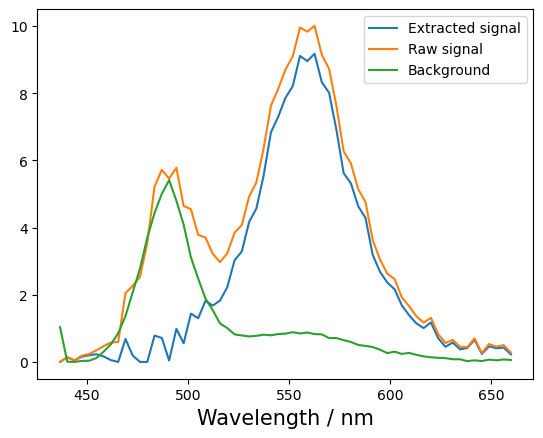

In [176]:
# Subtract background from signal
# Currently suboptimal and requires some manual fiddling

i=1 # Select spectrum to check
spectra = [spectrum1,spectrum2]
factors = [8,3] # Choose factors to match bg peak to raw signal peak
spectrum = spectra[i]
factor = factors[i]

# Extract corrected signal
newlamp = np.concatenate([lamp,[0]])[1:] # Align peaks
signal = spectrum-np.min(spectrum) - (newlamp - np.min(newlamp))*factor # Match peak intensities
signal[signal<0]=0

# Plot
plt.plot(wavelengths,signal)
plt.plot(wavelengths,spectrum-np.min(spectrum))
plt.plot(wavelengths,(newlamp - np.min(newlamp))*factor)
plt.xlabel('Wavelength / nm',fontsize=15)
plt.legend(['Extracted signal','Raw signal','Background'])

## Smooth and plot

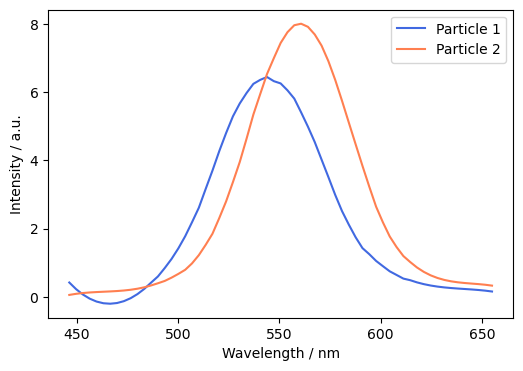

In [184]:
box,order=25,3

plt.figure(figsize=(6,4))

colors = ['royalblue','coral']

for i, spectrum in enumerate(spectra):
    factor = factors[i]
    signal = spectrum-np.min(spectrum) - (newlamp - np.min(newlamp))*factor # Match peak intensities
    signal[signal<0]=0
    yhat = savgol_filter(signal, box, order)
    xhat = savgol_filter(wavelengths, box, order)
    plt.plot(xhat,yhat,'-',color=colors[i])
    
plt.xlabel('Wavelength / nm')
plt.ylabel('Intensity / a.u.')

plt.legend(['Particle 1','Particle 2'])